# Introduction to the Keras Tuner

## Overview

The Keras Tuner is a library that helps you pick the optimal set of hyperparameters for your TensorFlow program. The process of selecting the right set of hyperparameters for your machine learning (ML) application is called *hyperparameter tuning* or *hypertuning*.

Hyperparameters are the variables that govern the training process and the topology of an ML model. These variables remain constant over the training process and directly impact the performance of your ML program. Hyperparameters are of two types:
1. **Model hyperparameters** which influence model selection such as the number and width of hidden layers
2. **Algorithm hyperparameters** which influence the speed and quality of the learning algorithm such as the learning rate for Stochastic Gradient Descent (SGD) and the number of nearest neighbors for a k Nearest Neighbors (KNN) classifier

In this tutorial, you will use the Keras Tuner to perform hypertuning for an image classification application.

## Setup

In [1]:
import tensorflow as tf
from tensorflow import keras

Install and import the Keras Tuner.

In [3]:
!pip install -q -U keras-tuner

In [4]:
import keras_tuner as kt

## Download and prepare the dataset

In this tutorial, you will use the Keras Tuner to find the best hyperparameters for a machine learning model that classifies images of clothing from the [Fashion MNIST dataset](https://github.com/zalandoresearch/fashion-mnist).

Load the data.

In [5]:
(img_train, label_train), (img_test, label_test) = keras.datasets.fashion_mnist.load_data()

In [6]:
# Normalize pixel values between 0 and 1
img_train = img_train.astype('float32') / 255.0
img_test = img_test.astype('float32') / 255.0

In [7]:
img_train

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [8]:
label_train

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

In [9]:
img_train[0].shape

(28, 28)

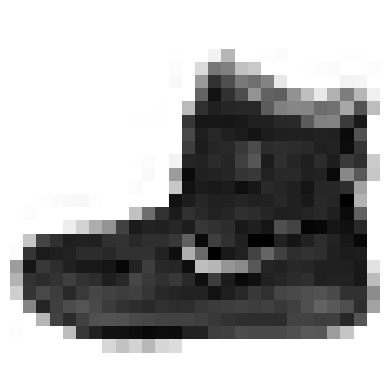

In [10]:
import matplotlib.pyplot as plt 
plt.imshow(img_train[0], cmap='binary')
plt.axis('off')
plt.show()

## Define the model

When you build a model for hypertuning, you also define the hyperparameter search space in addition to the model architecture. The model you set up for hypertuning is called a *hypermodel*.

You can define a hypermodel through two approaches:

* By using a model builder function
* By subclassing the `HyperModel` class of the Keras Tuner API

You can also use two pre-defined [HyperModel](https://keras.io/api/keras_tuner/hypermodels/) classes - [HyperXception](https://keras.io/api/keras_tuner/hypermodels/hyper_xception/) and [HyperResNet](https://keras.io/api/keras_tuner/hypermodels/hyper_resnet/) for computer vision applications.

In this tutorial, you use a model builder function to define the image classification model. The model builder function returns a compiled model and uses hyperparameters you define inline to hypertune the model.

In [11]:
def model_builder(hp):
  model = keras.Sequential()
    #input layer
  model.add(keras.layers.Flatten(input_shape=(28, 28)))

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
  model.add(keras.layers.Dense(units=hp_units, activation='relu'))
  model.add(keras.layers.Dense(10)) # output layer

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

  return model

## Instantiate the tuner and perform hypertuning

Instantiate the tuner to perform the hypertuning. The Keras Tuner has four tuners available - `RandomSearch`, `Hyperband`, `BayesianOptimization`, and `Sklearn`. In this tutorial, you use the [Hyperband](https://arxiv.org/pdf/1603.06560.pdf) tuner.

To instantiate the Hyperband tuner, you must specify the hypermodel, the `objective` to optimize and the maximum number of epochs to train (`max_epochs`).

In [12]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt')

INFO:tensorflow:Reloading Oracle from existing project my_dir\intro_to_kt\oracle.json
INFO:tensorflow:Reloading Tuner from my_dir\intro_to_kt\tuner0.json


The Hyperband tuning algorithm uses adaptive resource allocation and early-stopping to quickly converge on a high-performing model. This is done using a sports championship style bracket. The algorithm trains a large number of models for a few epochs and carries forward only the top-performing half of models to the next round. Hyperband determines the number of models to train in a bracket by computing 1 + log<sub>`factor`</sub>(`max_epochs`) and rounding it up to the nearest integer.

Create a callback to stop training early after reaching a certain value for the validation loss.

In [13]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

Run the hyperparameter search. The arguments for the search method are the same as those used for `tf.keras.model.fit` in addition to the callback above.

In [14]:
tuner.search(img_train, label_train, epochs=50, validation_split=0.2, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 416 and the optimal learning rate for the optimizer
is 0.001.



## Train the model

Find the optimal number of epochs to train the model with the hyperparameters obtained from the search.

In [15]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(img_train, label_train, epochs=50, validation_split=0.2)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/50
1500/1500 [==============================] - 19s 9ms/step - loss: 0.4942 - accuracy: 0.8250 - val_loss: 0.4020 - val_accuracy: 0.8530
Epoch 2/50
1500/1500 [==============================] - 12s 8ms/step - loss: 0.3725 - accuracy: 0.8646 - val_loss: 0.3668 - val_accuracy: 0.8654
Epoch 3/50
1500/1500 [==============================] - 11s 8ms/step - loss: 0.3304 - accuracy: 0.8782 - val_loss: 0.3493 - val_accuracy: 0.8742
Epoch 4/50
1500/1500 [==============================] - 12s 8ms/step - loss: 0.3058 - accuracy: 0.8860 - val_loss: 0.3446 - val_accuracy: 0.8755
Epoch 5/50
1500/1500 [==============================] - 13s 8ms/step - loss: 0.2873 - accuracy: 0.8932 - val_loss: 0.3428 - val_accuracy: 0.8773
Epoch 6/50
1500/1500 [==============================] - 12s 8ms/step - loss: 0.2714 - accuracy: 0.9007 - val_loss: 0.3267 - val_accuracy: 0.8820
Epoch 7/50
1500/1500 [==============================] - 13s 9ms/step - loss: 0.2566 - accuracy: 0.9032 - val_loss: 0.3205 - val_ac

Re-instantiate the hypermodel and train it with the optimal number of epochs from above.

In [16]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel.fit(img_train, label_train, epochs=best_epoch, validation_split=0.2)

Epoch 1/26
1500/1500 [==============================] - 14s 9ms/step - loss: 0.4923 - accuracy: 0.8252 - val_loss: 0.4205 - val_accuracy: 0.8432
Epoch 2/26
1500/1500 [==============================] - 13s 8ms/step - loss: 0.3732 - accuracy: 0.8637 - val_loss: 0.3707 - val_accuracy: 0.8656
Epoch 3/26
1500/1500 [==============================] - 13s 9ms/step - loss: 0.3329 - accuracy: 0.8764 - val_loss: 0.3441 - val_accuracy: 0.8767
Epoch 4/26
1500/1500 [==============================] - 13s 9ms/step - loss: 0.3067 - accuracy: 0.8853 - val_loss: 0.3349 - val_accuracy: 0.8794
Epoch 5/26
1500/1500 [==============================] - 13s 9ms/step - loss: 0.2878 - accuracy: 0.8927 - val_loss: 0.3251 - val_accuracy: 0.8843
Epoch 6/26
1500/1500 [==============================] - 13s 9ms/step - loss: 0.2727 - accuracy: 0.8986 - val_loss: 0.3413 - val_accuracy: 0.8760
Epoch 7/26
1500/1500 [==============================] - 13s 9ms/step - loss: 0.2581 - accuracy: 0.9027 - val_loss: 0.3225 - val_ac

To finish this tutorial, evaluate the hypermodel on the test data.

In [17]:
eval_result = hypermodel.evaluate(img_test, label_test)
print("[test loss, test accuracy]:", eval_result)

313/313 [==============================] - 3s 8ms/step - loss: 0.4389 - accuracy: 0.8845
[test loss, test accuracy]: [0.43890488147735596, 0.8845000267028809]


The `my_dir/intro_to_kt` directory contains detailed logs and checkpoints for every trial (model configuration) run during the hyperparameter search. If you re-run the hyperparameter search, the Keras Tuner uses the existing state from these logs to resume the search. To disable this behavior, pass an additional `overwrite=True` argument while instantiating the tuner.

## Summary

In this tutorial, you learned how to use the Keras Tuner to tune hyperparameters for a model. To learn more about the Keras Tuner, check out these additional resources:

* [Keras Tuner on the TensorFlow blog](https://blog.tensorflow.org/2020/01/hyperparameter-tuning-with-keras-tuner.html)
* [Keras Tuner website](https://keras-team.github.io/keras-tuner/)

Also check out the [HParams Dashboard](https://www.tensorflow.org/tensorboard/hyperparameter_tuning_with_hparams) in TensorBoard to interactively tune your model hyperparameters.